In [19]:
#import libraries
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

import zipfile
import os

**Step 1: Preprocessing Soundtracks & 4Q datasets**

In [14]:
# Assuming 'Set1.zip' is in the current directory
with zipfile.ZipFile('/Users/lindarcourt/Downloads/Set1.zip', 'r') as zip_ref:
    zip_ref.extractall('Set1')

# Now 'Set1' directory contains the unzipped audio files
Soundtracks_dataset_path = 'Set1'

In [64]:
def preprocess_audio(file_path, sr=44100, n_mels=128, duration=6):
    try:
        # Load the audio file (supports .mp3 format)
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure the audio length is 6 seconds
        if len(y) < duration * sr:
            padding = duration * sr - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # Short-Time Fourier Transform (STFT) with specified parameters
        stft = librosa.stft(y, n_fft=2048, hop_length=512, window='hann')
        stft_db = librosa.amplitude_to_db(abs(stft))
        
        # Convert STFT to Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=16384)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Adjust the dB scale by adding 20 dB
        mel_spectrogram_db += 20
        
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset(dataset_path):
    """
    Load and preprocess dataset.

    Args:
        dataset_path (str): Path to the dataset folder containing audio files.

    Returns:
        X (list): List of mel spectrograms.
        y (list): List of labels.
    """
    X = []
    y = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mp3') and not file.startswith('._'):  # Check for .mp3 files and ignore macOS hidden files
                file_path = os.path.join(root, file)
                mel_spectrogram = preprocess_audio(file_path)
                if mel_spectrogram is not None:
                    label = get_label_from_filename(file)  # Implement this function based on your label extraction logic
                    X.append(mel_spectrogram)
                    y.append(label)
    
    return X, y

def get_label_from_filename(filename):
    # Example: Extract label from filename
    # Assuming filename format: 'label_filename.mp3'
    # Adjust this logic based on your actual filename format
    label_part = filename.split('.')[0]  # Get part before .mp3
    return int(label_part.split('_')[0])  # Adjust as necessary

def plot_mel_spectrogram(mel_spectrogram, sr=22050):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=16384, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB', ticks=[-40, -20, 0, 20])
    plt.title('Mel Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.show()

In [66]:
# Example usage for the extracted dataset
Soundtracks_dataset_path = 'Set1'
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path)


Number of samples in X: 360
Number of labels in y: 360
Lengths of X and y match.
Shape of mel spectrogram 0: (128, 517)
Label 0: 34
Shape of mel spectrogram 1: (128, 517)
Label 1: 20
Shape of mel spectrogram 2: (128, 517)
Label 2: 8


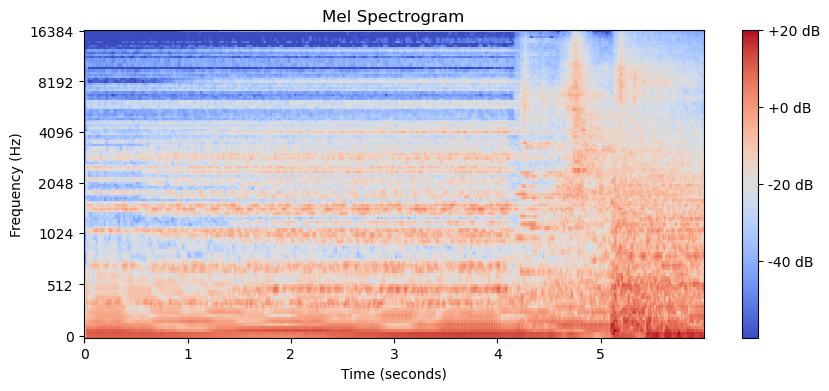

In [68]:
# Check the lengths of X and y
print(f"Number of samples in X: {len(X_Soundtracks)}")
print(f"Number of labels in y: {len(y_Soundtracks)}")

# Ensure that the lengths match
if len(X_Soundtracks) == len(y_Soundtracks):
    print("Lengths of X and y match.")
else:
    print("Mismatch in lengths of X and y.")

# Inspect the shape of the first few mel spectrograms
for i in range(3):
    print(f"Shape of mel spectrogram {i}: {X_Soundtracks[i].shape}")
    print(f"Label {i}: {y_Soundtracks[i]}")


# Test with a sample mel spectrogram
plot_mel_spectrogram(X_Soundtracks[50], sr=44100)

**Step 3: Defining model filters**

In [69]:
def harmonics_filter(input_layer, num_harmonics=10):
    filters = []
    for i in range(1, num_harmonics + 1):
        filter = layers.Conv2D(1, (i, 1), padding='same', activation='relu')(input_layer)
        filters.append(filter)
    return layers.Concatenate()(filters)

def octaves_filter(input_layer, num_octaves=8):
    filters = []
    for i in range(1, num_octaves + 1):
        filter = layers.Conv2D(1, (2**i, 1), padding='same', activation='relu')(input_layer)
        filters.append(filter)
    return layers.Concatenate()(filters)

def fifths_filter(input_layer, num_fifths=8):
    filters = []
    for i in range(1, num_fifths + 1):
        filter = layers.Conv2D(1, ((3/2)**i, 1), padding='same', activation='relu')(input_layer)
        filters.append(filter)
    return layers.Concatenate()(filters)


In [ ]:
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path)
X_4q, y_4q = load_dataset(fourq_dataset_path)

# Convert lists to numpy arrays and reshape for the model
X_soundtracks = np.array(X_soundtracks).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary
X_4q = np.array(X_4q).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary